# VGG16 Furniture Classification Experiments

This notebook trains VGG16 on furniture profitability classification with three data configurations:
- **all**: All data in dataset
- **high_quality**: High confidence predictions (≥0.8 confidence score for any tabular column)
- **brand_msrp_only**: Only listings with known brand and MSRP data

In [6]:
# Login to HuggingFace to access private dataset
from huggingface_hub import login

login()

In [ ]:
import sys
sys.path.append('..')

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
import numpy as np
import pandas as pd
from pathlib import Path

from image_only.dataset_utils import load_and_split_hf_data, get_hf_data_loaders, DATASET_REPO
from image_only.training_utils import (
    train_model, evaluate_model, plot_training_history, 
    plot_confusion_matrix, visualize_misclassified,
    save_experiment_results, print_experiment_summary
)

# Set random seeds for reproducability across experiments
torch.manual_seed(42)
np.random.seed(42)

# Device config
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
    print(f"Using device: CUDA - {torch.cuda.get_device_name(0)}")
else:
    DEVICE = torch.device('cpu')
    print(f"Using device: CPU")

# Paths
RESULTS_DIR = Path('results/vgg16')
MODELS_DIR = Path('models/vgg16')
RESULTS_DIR.mkdir(parents=True, exist_ok=True)
MODELS_DIR.mkdir(parents=True, exist_ok=True)

print(f"Using HuggingFace dataset: {DATASET_REPO}")

Using device: CUDA - Tesla V100-SXM2-16GB
Using HuggingFace dataset: adybacki/furniture-profitability-dataset


## Data Transforms

In [8]:
# VGG16 expects 224x224 images with ImageNet normalization
IMAGE_SIZE = 224
IMAGE_MEAN = [0.485, 0.456, 0.406]
IMAGE_STD = [0.229, 0.224, 0.225]

# Data augmentatino and normalization for training
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGE_MEAN, std=IMAGE_STD)
])

## Model Definition

In [9]:
def create_vgg16_model():
    """
    Create VGG16 model for binary classification (buy or not)
    """
    # Load pre-trained VGG16
    model = models.vgg16(pretrained=True)
    
    # Freeze feature extraction layers
    for param in model.features.parameters():
        param.requires_grad = False

    # VGG16 features output is 25088 (512 * 7 * 7)
    model.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Dropout(0.5),
        nn.Linear(25088, 256),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(256, 2)
    )
    
    return model

## Training Configuration

In [10]:
# Hyperparameters
BATCH_SIZE = 32
NUM_EPOCHS = 15
LEARNING_RATE = 0.0001

# Data modes to test
DATA_MODES = ['all', 'high_quality', 'brand_msrp_only']

## Experiment Loop

Run experiments for all three data configurations


EXPERIMENT: VGG16 with ALL data

Loading dataset from HuggingFace: adybacki/furniture-profitability-dataset
Loaded 26,554 total samples

Filtering for data_mode: all
26,554 samples after filtering

Original class distribution: {0: 18078, 1: 8476}
Balancing classes to 8476 samples each...
Balanced class distribution: {0: 8476, 1: 8476}

Train samples: 13561
Validation samples: 1695
Test samples: 1696
Dataset initialized with 13561 samples
Class distribution: {1: 6781, 0: 6780}
Dataset initialized with 1695 samples
Class distribution: {0: 848, 1: 847}
Dataset initialized with 1696 samples
Class distribution: {0: 848, 1: 848}


/share/pkg.8/academic-ml/fall-2025/install/fall-2025-pyt/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/share/pkg.8/academic-ml/fall-2025/install/fall-2025-pyt/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Training vgg16_all



────────────────────────────────────────────────────────────
EPOCH 1/15 COMPLETE - Time: 76.89s
────────────────────────────────────────────────────────────
Train - Loss: 0.7005 | Acc: 0.5421 | F1: 0.5328
Val   - Loss: 0.6791 | Acc: 0.5617 | F1: 0.5951
New best model saved (F1: 0.5951)
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
EPOCH 2/15 COMPLETE - Time: 75.77s
────────────────────────────────────────────────────────────
Train - Loss: 0.6744 | Acc: 0.5814 | F1: 0.5815
Val   - Loss: 0.6779 | Acc: 0.5693 | F1: 0.4664
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
EPOCH 3/15 COMPLETE - Time: 75.96s
────────────────────────────────────────────────────────────
Train - Loss: 0.6637 | Acc: 0.5959 | F1: 0.5966
Val   - Loss: 0.6753 | Acc: 0.5811 | F1: 0.5286
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
EPOCH 4/15 COMPLETE - Time: 76.29s
────────────────────────────────────────────────────────────
Train - Loss: 0.6563 | Acc: 0.6036 | F1: 0.6018
Val   - Loss: 0.6771 | Acc: 0.5823 | F1: 0.5110
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
EPOCH 5/15 COMPLETE - Time: 76.19s
────────────────────────────────────────────────────────────
Train - Loss: 0.6500 | Acc: 0.6161 | F1: 0.6166
Val   - Loss: 0.6723 | Acc: 0.5923 | F1: 0.6205
New best model saved (F1: 0.6205)
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
EPOCH 6/15 COMPLETE - Time: 76.02s
────────────────────────────────────────────────────────────
Train - Loss: 0.6394 | Acc: 0.6292 | F1: 0.6283
Val   - Loss: 0.6766 | Acc: 0.5923 | F1: 0.5068
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
EPOCH 7/15 COMPLETE - Time: 77.43s
────────────────────────────────────────────────────────────
Train - Loss: 0.6312 | Acc: 0.6393 | F1: 0.6393
Val   - Loss: 0.6777 | Acc: 0.5870 | F1: 0.6137
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
EPOCH 8/15 COMPLETE - Time: 75.59s
────────────────────────────────────────────────────────────
Train - Loss: 0.6256 | Acc: 0.6402 | F1: 0.6443
Val   - Loss: 0.6774 | Acc: 0.5723 | F1: 0.4419
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
EPOCH 9/15 COMPLETE - Time: 76.98s
────────────────────────────────────────────────────────────
Train - Loss: 0.6177 | Acc: 0.6505 | F1: 0.6499
Val   - Loss: 0.6798 | Acc: 0.5906 | F1: 0.5748
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
EPOCH 10/15 COMPLETE - Time: 77.16s
────────────────────────────────────────────────────────────
Train - Loss: 0.6127 | Acc: 0.6522 | F1: 0.6544
Val   - Loss: 0.6788 | Acc: 0.5876 | F1: 0.5725
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
EPOCH 11/15 COMPLETE - Time: 77.43s
────────────────────────────────────────────────────────────
Train - Loss: 0.5994 | Acc: 0.6631 | F1: 0.6659
Val   - Loss: 0.6801 | Acc: 0.5817 | F1: 0.5626
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
EPOCH 12/15 COMPLETE - Time: 75.77s
────────────────────────────────────────────────────────────
Train - Loss: 0.5943 | Acc: 0.6714 | F1: 0.6736
Val   - Loss: 0.6686 | Acc: 0.6094 | F1: 0.6251
New best model saved (F1: 0.6251)
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
EPOCH 13/15 COMPLETE - Time: 76.55s
────────────────────────────────────────────────────────────
Train - Loss: 0.5826 | Acc: 0.6803 | F1: 0.6831
Val   - Loss: 0.6749 | Acc: 0.6047 | F1: 0.6417
New best model saved (F1: 0.6417)
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
EPOCH 14/15 COMPLETE - Time: 76.98s
────────────────────────────────────────────────────────────
Train - Loss: 0.5781 | Acc: 0.6845 | F1: 0.6888
Val   - Loss: 0.6759 | Acc: 0.5988 | F1: 0.5899
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
EPOCH 15/15 COMPLETE - Time: 76.26s
────────────────────────────────────────────────────────────
Train - Loss: 0.5718 | Acc: 0.6898 | F1: 0.6920
Val   - Loss: 0.6842 | Acc: 0.6018 | F1: 0.6501
New best model saved (F1: 0.6501)
────────────────────────────────────────────────────────────

TRAINING COMPLETE - vgg16_all
Best Validation F1: 0.6501
Total Epochs: 15


EXPERIMENT SUMMARY
Model: VGG16
Data Mode: all

Test Set Performance:
  Accuracy:  0.5967
  F1 Score:  0.6449
  Precision: 0.5761
  Recall:    0.7323



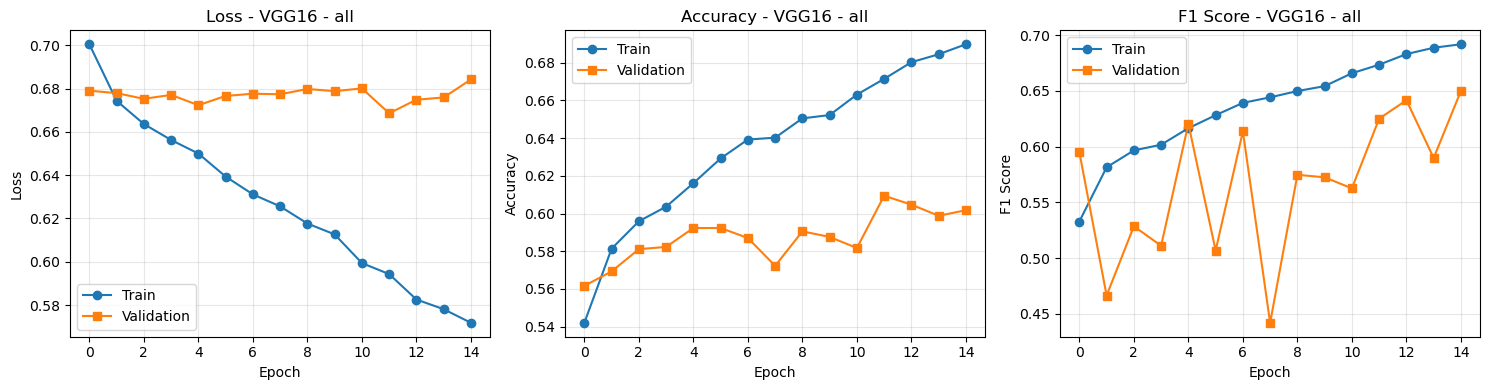

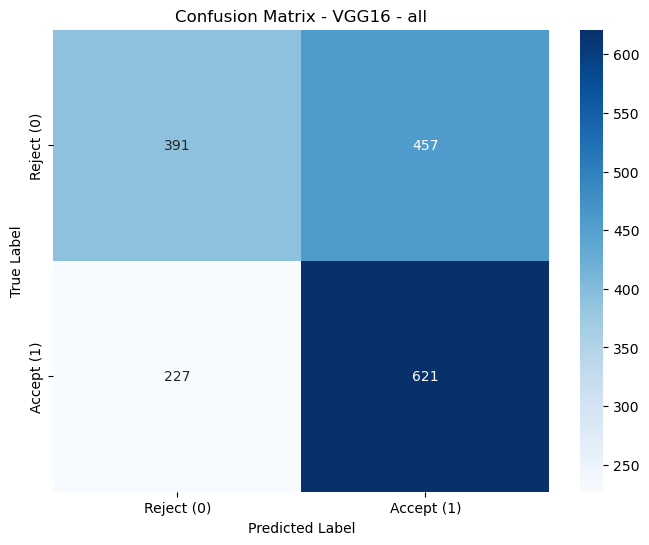


Analyzing misclassified examples...


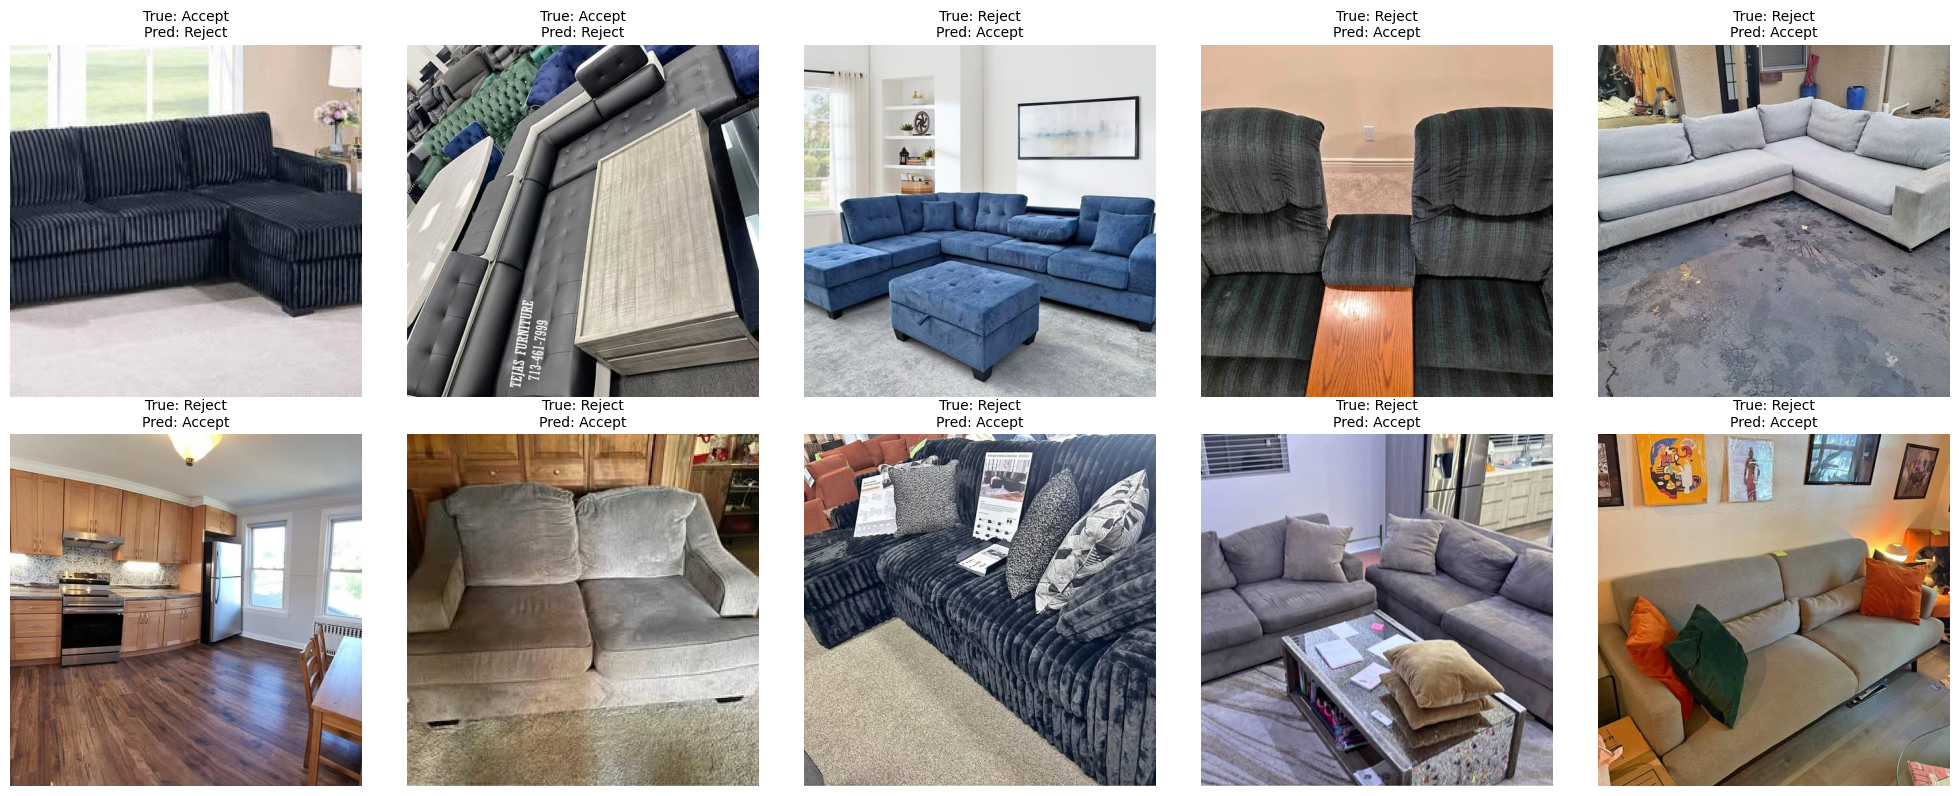

Results saved to results/vgg16/vgg16_all_results.json

EXPERIMENT: VGG16 with HIGH_QUALITY data

Loading dataset from HuggingFace: adybacki/furniture-profitability-dataset
Loaded 26,554 total samples

Filtering for data_mode: high_quality
12,846 samples after filtering

Original class distribution: {0: 6437, 1: 6409}

Train samples: 10276
Validation samples: 1285
Test samples: 1285
Dataset initialized with 10276 samples
Class distribution: {0: 5149, 1: 5127}
Dataset initialized with 1285 samples
Class distribution: {0: 644, 1: 641}
Dataset initialized with 1285 samples
Class distribution: {0: 644, 1: 641}


/share/pkg.8/academic-ml/fall-2025/install/fall-2025-pyt/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/share/pkg.8/academic-ml/fall-2025/install/fall-2025-pyt/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Training vgg16_high_quality



────────────────────────────────────────────────────────────
EPOCH 1/15 COMPLETE - Time: 58.89s
────────────────────────────────────────────────────────────
Train - Loss: 0.6969 | Acc: 0.5500 | F1: 0.5505
Val   - Loss: 0.6689 | Acc: 0.5953 | F1: 0.6296
New best model saved (F1: 0.6296)
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
EPOCH 2/15 COMPLETE - Time: 58.58s
────────────────────────────────────────────────────────────
Train - Loss: 0.6637 | Acc: 0.5959 | F1: 0.6019
Val   - Loss: 0.6548 | Acc: 0.6140 | F1: 0.6482
New best model saved (F1: 0.6482)
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
EPOCH 3/15 COMPLETE - Time: 58.67s
────────────────────────────────────────────────────────────
Train - Loss: 0.6521 | Acc: 0.6127 | F1: 0.6212
Val   - Loss: 0.6622 | Acc: 0.6086 | F1: 0.5381
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
EPOCH 4/15 COMPLETE - Time: 58.60s
────────────────────────────────────────────────────────────
Train - Loss: 0.6408 | Acc: 0.6210 | F1: 0.6245
Val   - Loss: 0.6515 | Acc: 0.6125 | F1: 0.6626
New best model saved (F1: 0.6626)
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
EPOCH 5/15 COMPLETE - Time: 58.22s
────────────────────────────────────────────────────────────
Train - Loss: 0.6310 | Acc: 0.6342 | F1: 0.6388
Val   - Loss: 0.6569 | Acc: 0.6148 | F1: 0.6124
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
EPOCH 6/15 COMPLETE - Time: 58.50s
────────────────────────────────────────────────────────────
Train - Loss: 0.6189 | Acc: 0.6510 | F1: 0.6587
Val   - Loss: 0.6496 | Acc: 0.6280 | F1: 0.5701
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
EPOCH 7/15 COMPLETE - Time: 59.51s
────────────────────────────────────────────────────────────
Train - Loss: 0.6127 | Acc: 0.6540 | F1: 0.6602
Val   - Loss: 0.6497 | Acc: 0.6265 | F1: 0.6512
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
EPOCH 8/15 COMPLETE - Time: 59.28s
────────────────────────────────────────────────────────────
Train - Loss: 0.6012 | Acc: 0.6607 | F1: 0.6666
Val   - Loss: 0.6441 | Acc: 0.6350 | F1: 0.6412
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
EPOCH 9/15 COMPLETE - Time: 58.57s
────────────────────────────────────────────────────────────
Train - Loss: 0.5886 | Acc: 0.6746 | F1: 0.6791
Val   - Loss: 0.6549 | Acc: 0.6304 | F1: 0.5957
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
EPOCH 10/15 COMPLETE - Time: 58.38s
────────────────────────────────────────────────────────────
Train - Loss: 0.5852 | Acc: 0.6738 | F1: 0.6805
Val   - Loss: 0.6518 | Acc: 0.6218 | F1: 0.5943
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
EPOCH 11/15 COMPLETE - Time: 57.99s
────────────────────────────────────────────────────────────
Train - Loss: 0.5699 | Acc: 0.6937 | F1: 0.7002
Val   - Loss: 0.6546 | Acc: 0.6467 | F1: 0.6339
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
EPOCH 12/15 COMPLETE - Time: 58.32s
────────────────────────────────────────────────────────────
Train - Loss: 0.5641 | Acc: 0.6979 | F1: 0.7039
Val   - Loss: 0.6551 | Acc: 0.6109 | F1: 0.6274
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
EPOCH 13/15 COMPLETE - Time: 58.41s
────────────────────────────────────────────────────────────
Train - Loss: 0.5553 | Acc: 0.7052 | F1: 0.7097
Val   - Loss: 0.6492 | Acc: 0.6233 | F1: 0.6207
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
EPOCH 14/15 COMPLETE - Time: 58.11s
────────────────────────────────────────────────────────────
Train - Loss: 0.5445 | Acc: 0.7103 | F1: 0.7151
Val   - Loss: 0.6784 | Acc: 0.6171 | F1: 0.6120
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
EPOCH 15/15 COMPLETE - Time: 58.01s
────────────────────────────────────────────────────────────
Train - Loss: 0.5338 | Acc: 0.7162 | F1: 0.7212
Val   - Loss: 0.6764 | Acc: 0.6008 | F1: 0.6057
────────────────────────────────────────────────────────────

TRAINING COMPLETE - vgg16_high_quality
Best Validation F1: 0.6626
Total Epochs: 15


EXPERIMENT SUMMARY
Model: VGG16
Data Mode: high_quality

Test Set Performance:
  Accuracy:  0.5992
  F1 Score:  0.6551
  Precision: 0.5739
  Recall:    0.7629



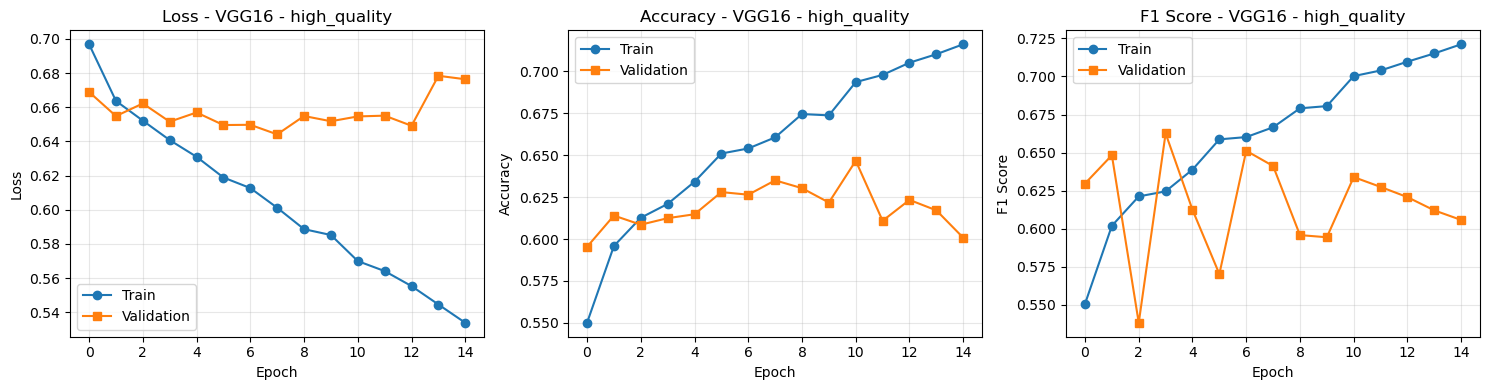

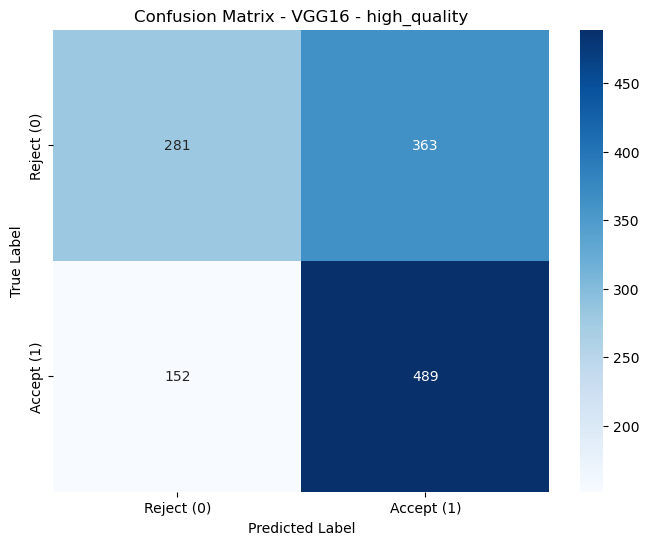


Analyzing misclassified examples...


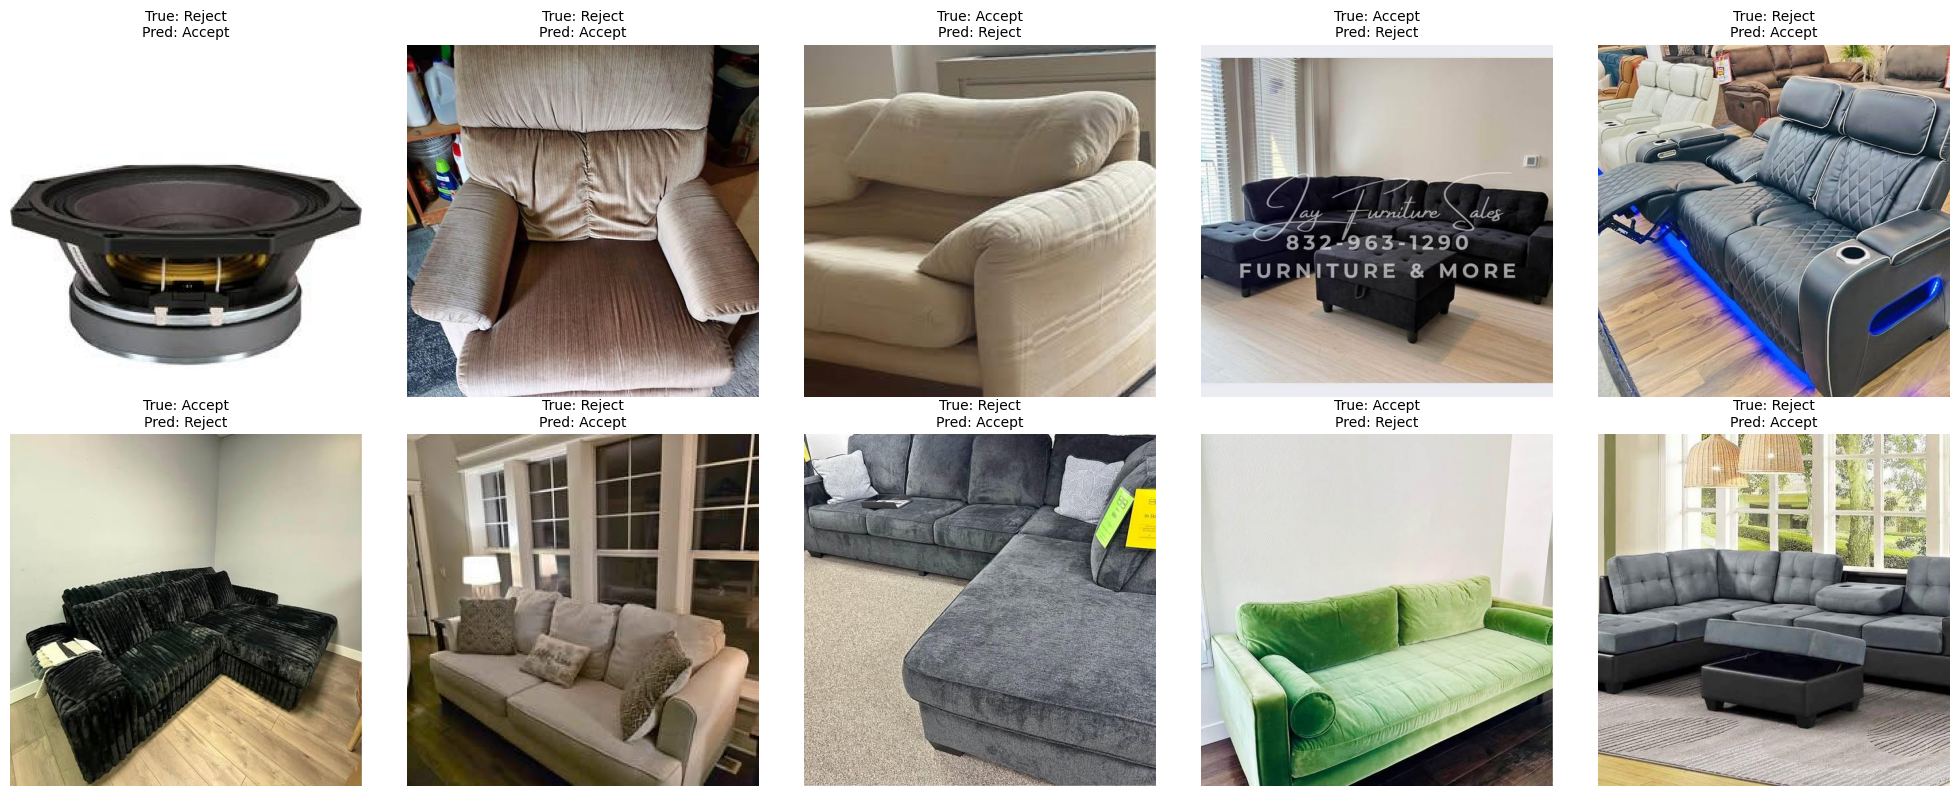

Results saved to results/vgg16/vgg16_high_quality_results.json

EXPERIMENT: VGG16 with BRAND_MSRP_ONLY data

Loading dataset from HuggingFace: adybacki/furniture-profitability-dataset
Loaded 26,554 total samples

Filtering for data_mode: brand_msrp_only
5,209 samples after filtering

Original class distribution: {1: 3499, 0: 1710}
Balancing classes to 1710 samples each...
Balanced class distribution: {1: 1710, 0: 1710}

Train samples: 2736
Validation samples: 342
Test samples: 342
Dataset initialized with 2736 samples
Class distribution: {0: 1368, 1: 1368}
Dataset initialized with 342 samples
Class distribution: {0: 171, 1: 171}
Dataset initialized with 342 samples
Class distribution: {1: 171, 0: 171}


/share/pkg.8/academic-ml/fall-2025/install/fall-2025-pyt/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/share/pkg.8/academic-ml/fall-2025/install/fall-2025-pyt/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Training vgg16_brand_msrp_only



────────────────────────────────────────────────────────────
EPOCH 1/15 COMPLETE - Time: 15.83s
────────────────────────────────────────────────────────────
Train - Loss: 0.7146 | Acc: 0.5691 | F1: 0.5739
Val   - Loss: 0.6460 | Acc: 0.6140 | F1: 0.6780
New best model saved (F1: 0.6780)
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
EPOCH 2/15 COMPLETE - Time: 15.90s
────────────────────────────────────────────────────────────
Train - Loss: 0.6438 | Acc: 0.6305 | F1: 0.6359
Val   - Loss: 0.6472 | Acc: 0.6257 | F1: 0.6503
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
EPOCH 3/15 COMPLETE - Time: 16.06s
────────────────────────────────────────────────────────────
Train - Loss: 0.6173 | Acc: 0.6466 | F1: 0.6545
Val   - Loss: 0.6416 | Acc: 0.6550 | F1: 0.6722
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
EPOCH 4/15 COMPLETE - Time: 15.85s
────────────────────────────────────────────────────────────
Train - Loss: 0.6139 | Acc: 0.6575 | F1: 0.6628
Val   - Loss: 0.6293 | Acc: 0.6491 | F1: 0.6825
New best model saved (F1: 0.6825)
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
EPOCH 5/15 COMPLETE - Time: 15.65s
────────────────────────────────────────────────────────────
Train - Loss: 0.5846 | Acc: 0.6798 | F1: 0.6844
Val   - Loss: 0.6509 | Acc: 0.6170 | F1: 0.6843
New best model saved (F1: 0.6843)
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
EPOCH 6/15 COMPLETE - Time: 15.47s
────────────────────────────────────────────────────────────
Train - Loss: 0.5643 | Acc: 0.7018 | F1: 0.7031
Val   - Loss: 0.6366 | Acc: 0.6404 | F1: 0.6886
New best model saved (F1: 0.6886)
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
EPOCH 7/15 COMPLETE - Time: 15.80s
────────────────────────────────────────────────────────────
Train - Loss: 0.5456 | Acc: 0.7135 | F1: 0.7194
Val   - Loss: 0.6420 | Acc: 0.6433 | F1: 0.6164
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
EPOCH 8/15 COMPLETE - Time: 16.20s
────────────────────────────────────────────────────────────
Train - Loss: 0.5336 | Acc: 0.7204 | F1: 0.7273
Val   - Loss: 0.6714 | Acc: 0.5994 | F1: 0.4869
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
EPOCH 9/15 COMPLETE - Time: 16.39s
────────────────────────────────────────────────────────────
Train - Loss: 0.5085 | Acc: 0.7445 | F1: 0.7463
Val   - Loss: 0.6549 | Acc: 0.6404 | F1: 0.6838
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
EPOCH 10/15 COMPLETE - Time: 16.32s
────────────────────────────────────────────────────────────
Train - Loss: 0.5030 | Acc: 0.7471 | F1: 0.7495
Val   - Loss: 0.6454 | Acc: 0.6608 | F1: 0.7041
New best model saved (F1: 0.7041)
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
EPOCH 11/15 COMPLETE - Time: 16.15s
────────────────────────────────────────────────────────────
Train - Loss: 0.4756 | Acc: 0.7705 | F1: 0.7738
Val   - Loss: 0.6625 | Acc: 0.6520 | F1: 0.6667
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
EPOCH 12/15 COMPLETE - Time: 16.05s
────────────────────────────────────────────────────────────
Train - Loss: 0.4836 | Acc: 0.7485 | F1: 0.7550
Val   - Loss: 0.6754 | Acc: 0.6550 | F1: 0.6570
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
EPOCH 13/15 COMPLETE - Time: 16.06s
────────────────────────────────────────────────────────────
Train - Loss: 0.4558 | Acc: 0.7814 | F1: 0.7840
Val   - Loss: 0.6746 | Acc: 0.6082 | F1: 0.5786
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
EPOCH 14/15 COMPLETE - Time: 15.41s
────────────────────────────────────────────────────────────
Train - Loss: 0.4425 | Acc: 0.7887 | F1: 0.7897
Val   - Loss: 0.6903 | Acc: 0.6404 | F1: 0.6720
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
EPOCH 15/15 COMPLETE - Time: 15.29s
────────────────────────────────────────────────────────────
Train - Loss: 0.4182 | Acc: 0.8001 | F1: 0.8016
Val   - Loss: 0.6932 | Acc: 0.6316 | F1: 0.6719
────────────────────────────────────────────────────────────

TRAINING COMPLETE - vgg16_brand_msrp_only
Best Validation F1: 0.7041
Total Epochs: 15


EXPERIMENT SUMMARY
Model: VGG16
Data Mode: brand_msrp_only

Test Set Performance:
  Accuracy:  0.6462
  F1 Score:  0.6841
  Precision: 0.6179
  Recall:    0.7661



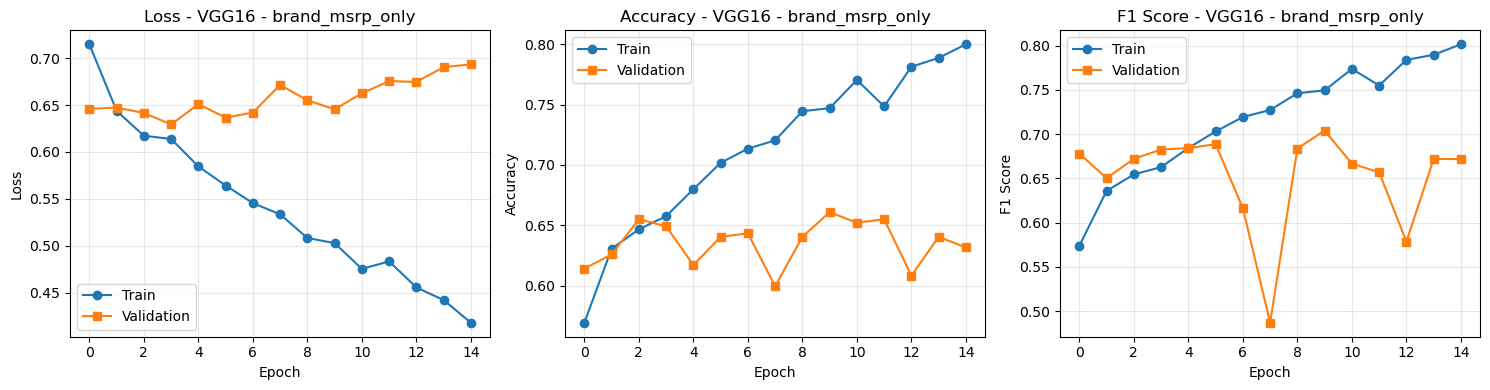

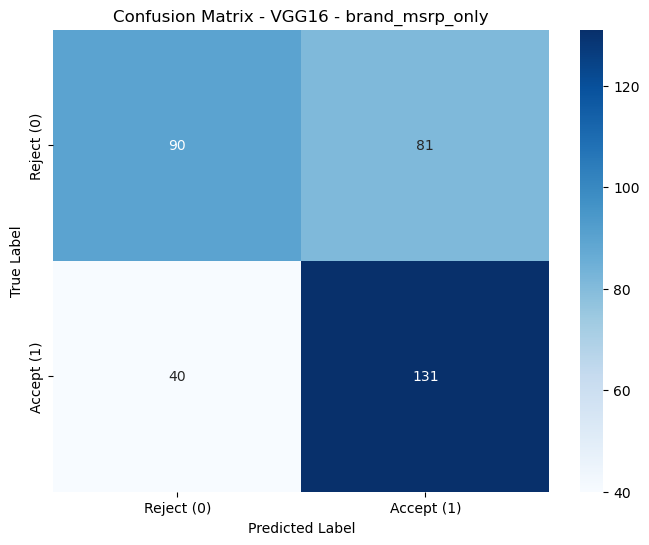


Analyzing misclassified examples...


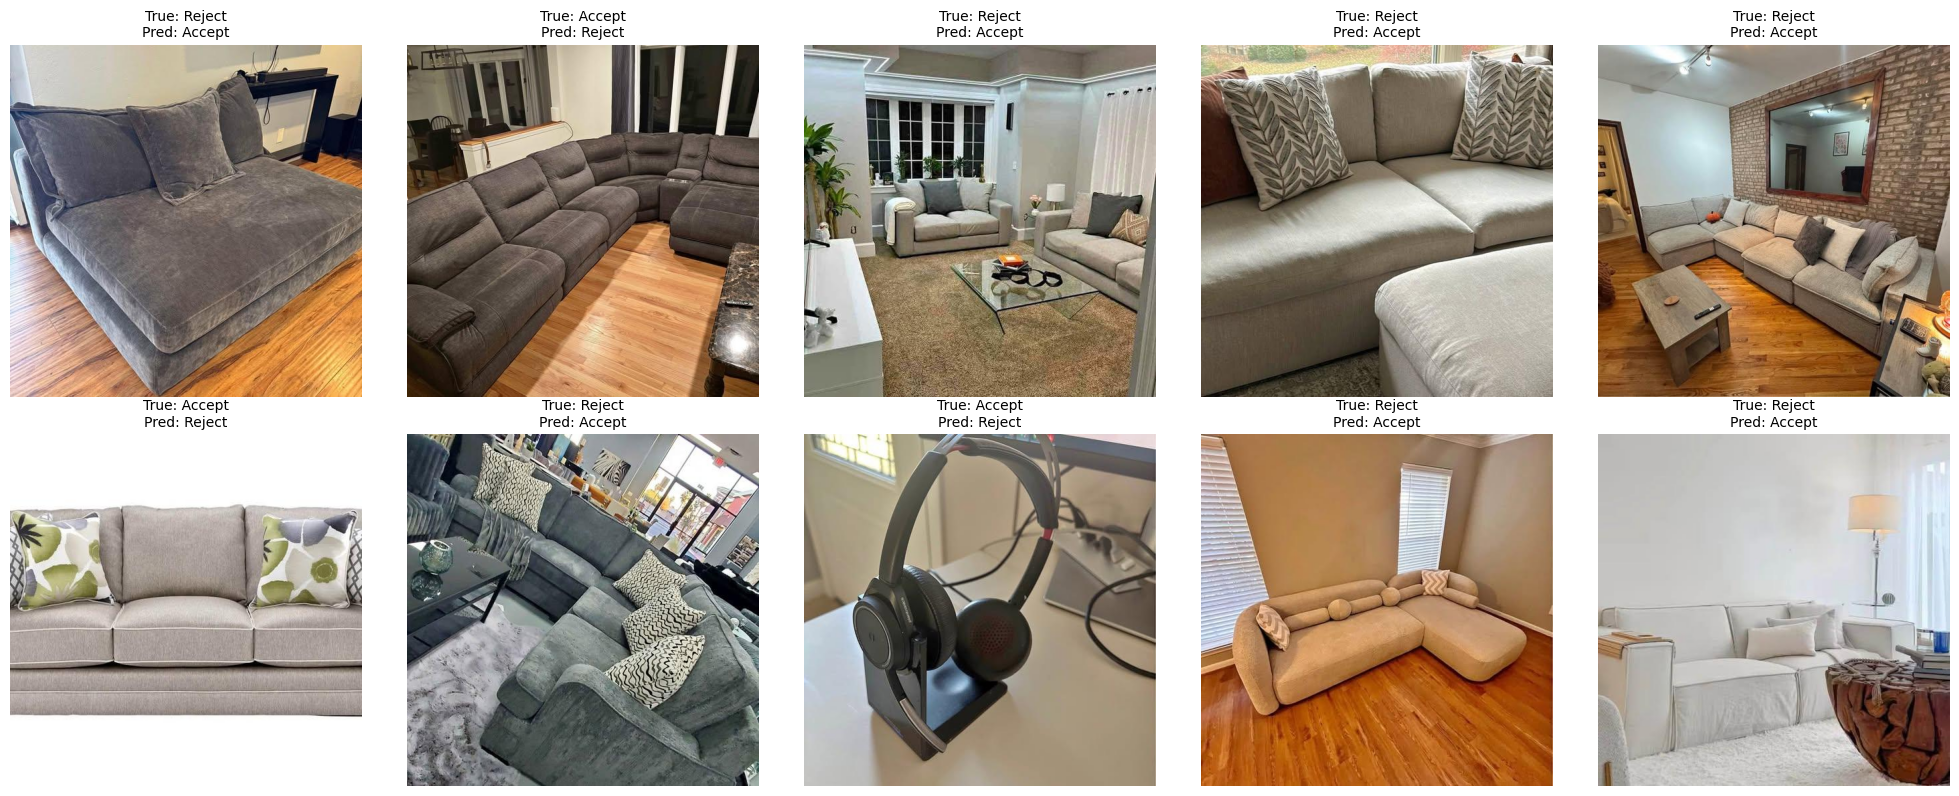

Results saved to results/vgg16/vgg16_brand_msrp_only_results.json


In [11]:
all_results = {}

for data_mode in DATA_MODES:
    print(f"\n{'='*80}")
    print(f"EXPERIMENT: VGG16 with {data_mode.upper()} data")
    print(f"{'='*80}\n")
    
    # Load and split data from HuggingFace
    train_idx, val_idx, test_idx, hf_dataset = load_and_split_hf_data(
        DATASET_REPO,
        data_mode=data_mode,
        test_size=0.2,
        random_state=42
    )
    
    # Create data loaders
    train_loader, val_loader, test_loader, train_dataset, val_dataset, test_dataset = get_hf_data_loaders(
        train_idx, val_idx, test_idx, hf_dataset,
        transform, transform,
        batch_size=BATCH_SIZE
    )
    
    # Create model
    model = create_vgg16_model()
    model = model.to(DEVICE)
    
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.classifier.parameters(), lr=LEARNING_RATE)
    
    # Train model
    model_name = f"vgg16_{data_mode}"
    history = train_model(
        model, train_loader, val_loader, criterion, optimizer,
        DEVICE, NUM_EPOCHS, model_name, save_dir=MODELS_DIR
    )
    
    # Load best model for evaluation
    model.load_state_dict(torch.load(MODELS_DIR / f"{model_name}_best.pth"))
    
    # Evaluate on test set
    test_results = evaluate_model(model, test_loader, criterion, DEVICE)
    
    # Store results
    all_results[data_mode] = {
        'model_name': 'VGG16',
        'data_mode': data_mode,
        'num_epochs': NUM_EPOCHS,
        'batch_size': BATCH_SIZE,
        'learning_rate': LEARNING_RATE,
        'train_samples': len(train_dataset),
        'val_samples': len(val_dataset),
        'test_samples': len(test_dataset),
        'test_accuracy': test_results['accuracy'],
        'test_f1': test_results['f1'],
        'test_precision': test_results['precision'],
        'test_recall': test_results['recall'],
        'history': history
    }
    
    # Print summary
    print_experiment_summary(all_results[data_mode])
    
    # Plot training history
    plot_training_history(
        history, 
        f"VGG16 - {data_mode}",
        save_path=RESULTS_DIR / f"training_history_{data_mode}.png"
    )
    
    # Plot confusion matrix
    plot_confusion_matrix(
        test_results['labels'],
        test_results['predictions'],
        f"VGG16 - {data_mode}",
        save_path=RESULTS_DIR / f"confusion_matrix_{data_mode}.png"
    )
    
    # Visualize misclassified examples
    print("\nAnalyzing misclassified examples...")
    visualize_misclassified(
        model, test_dataset, DEVICE, 
        num_examples=10,
        save_path=RESULTS_DIR / f"misclassified_{data_mode}.png"
    )
    
    # Save results
    save_experiment_results(
        all_results[data_mode],
        f"vgg16_{data_mode}",
        save_dir=RESULTS_DIR
    )

## Compare Results Across Data Modes


VGG16 RESULTS COMPARISON
      Data Mode  Train Size  Test Accuracy  Test F1  Test Precision  Test Recall
            All       13561       0.596698 0.644860        0.576067     0.732311
   High Quality       10276       0.599222 0.655057        0.573944     0.762871
Brand Msrp Only        2736       0.646199 0.684073        0.617925     0.766082



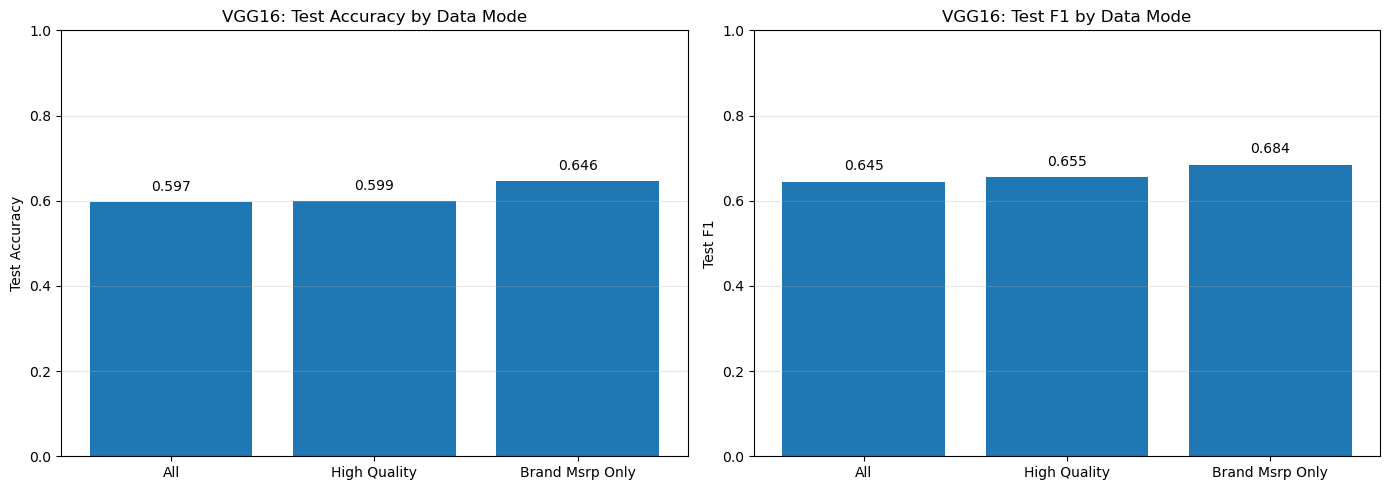

In [12]:
import matplotlib.pyplot as plt

# Create comparison dataframe
comparison_df = pd.DataFrame([
    {
        'Data Mode': mode.replace('_', ' ').title(),
        'Train Size': results['train_samples'],
        'Test Accuracy': results['test_accuracy'],
        'Test F1': results['test_f1'],
        'Test Precision': results['test_precision'],
        'Test Recall': results['test_recall']
    }
    for mode, results in all_results.items()
])

print("\n" + "="*80)
print("VGG16 RESULTS COMPARISON")
print("="*80)
print(comparison_df.to_string(index=False))
print("="*80 + "\n")

# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

metrics = ['Test Accuracy', 'Test F1']
for ax, metric in zip(axes, metrics):
    ax.bar(comparison_df['Data Mode'], comparison_df[metric])
    ax.set_ylabel(metric)
    ax.set_title(f'VGG16: {metric} by Data Mode')
    ax.set_ylim([0, 1])
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for i, v in enumerate(comparison_df[metric]):
        ax.text(i, v + 0.02, f'{v:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'vgg16_comparison.png', dpi=300, bbox_inches='tight')
plt.show()